All code based on

https://www.kaggle.com/code/ajitrajput/semantic-search-engine-using-nlp/notebook

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

## Tokenize

In [3]:
df_movies = pd.read_csv('../raw_data/wiki_movie_plots_deduped.csv')
df_movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [8]:
# Install the spacy model
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(sentence):
    sentence = re.sub('\'','',sentence)
    sentence = re.sub('\w*\d\w*','',sentence)
    sentence = re.sub(' +',' ',sentence)
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    sentence = re.sub(r'\n',' ',sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    tokens = spacy_nlp(sentence)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    return tokens

In [ ]:
print ('Cleaning and Tokenizing...') # 28 minutes!
df_movies['wiki_plot_tokenized'] = df_movies['Plot'].map(lambda x: tokenizer(x))

df_movies.head()

Cleaning and Tokenizing...


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,wiki_plot_tokenized
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...","[bartender, work, saloon, serve, drink, custom..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...","[moon, paint, smile, face, hang, park, night, ..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...","[film, minute, long, compose, shot, girl, sit,..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,"[second, consist, shot, shot, set, wood, winte..."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,"[early, know, adaptation, classic, fairytale, ..."


In [ ]:
# Save the DataFrame as a CSV file in the raw_data folder
df_movies.to_csv('../raw_data/movies_with_tokenized_plots.csv', index=False)

## Load tokenized data

In [ ]:
df_movies = pd.read_csv('../raw_data/movies_with_tokenized_plots.csv')
df_movies.head()

In [6]:
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [bartender, work, saloon, serve, drink, custom...
1    [moon, paint, smile, face, hang, park, night, ...
2    [film, minute, long, compose, shot, girl, sit,...
3    [second, consist, shot, shot, set, wood, winte...
4    [early, know, adaptation, classic, fairytale, ...
Name: wiki_plot_tokenized, dtype: object

In [7]:
sorted(movie_plot[0])

['appear',
 'assault',
 'bar',
 'bartender',
 'bartender',
 'beer',
 'beer',
 'begin',
 'break',
 'bucket',
 'burst',
 'carrie',
 'cash',
 'customer',
 'drink',
 'dump',
 'everybody',
 'eye',
 'face',
 'fill',
 'fixture',
 'follower',
 'group',
 'group',
 'hat',
 'head',
 'inside',
 'irish',
 'irish',
 'leave',
 'man',
 'man',
 'mirror',
 'nation',
 'nations',
 'order',
 'policeman',
 'pull',
 'register',
 'saloon',
 'seltzer',
 'serve',
 'smash',
 'spray',
 'stereotypically',
 'water',
 'work',
 'wreck']

Concatenate all the arrays in `movie_plot`, convert the result into a Pandas Series, count the frequency of each unique value, and select the top 100 most frequent values. Create a word cloud where the size of each word is proportional to its frequency.

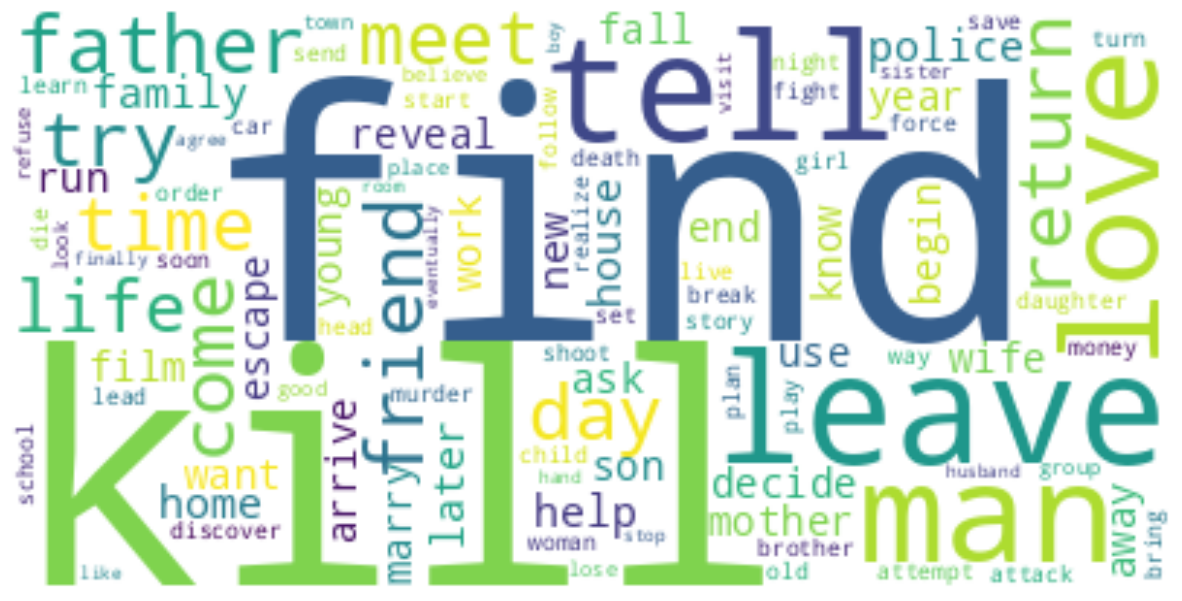

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Dictionary Creation¶

In `gensim`, words are referred as “tokens” and the index of each word in the dictionary is called ID.

Create a Dictionary object from the `movie_plot` list. Each unique token in `movie_plot` is assigned a unique integer ID. Create a list of token IDs for the stop words in the set `stoplist`. Creates a list of token IDs for the stop words and filter out the tokens with theses IDs from `dictionary`.

All the tokens in the dictionary which either have occurred in less than 4 articles or have occurred in more than 20% of the articles are removed from the dictionary, as these words will not be contributing to the various themes or topics.

In [9]:
from gensim import corpora

dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

stoplist = set('hello and if this can would should could tell ask stop come go'.split())
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

In [10]:
stoplist

{'and',
 'ask',
 'can',
 'come',
 'could',
 'go',
 'hello',
 'if',
 'should',
 'stop',
 'tell',
 'this',
 'would'}

In [11]:
stop_ids

[849, 319, 12402, 202, 315]

Iterate over each (token ID, token) pair in the dictionary, including only first 50 tokens. For each token ID (`key`) create a list of a token (`dictionary[key]`) and its key (`dictionary.token2id[dictionary[key]]`). Create a list of these lists `dict_tokens`.

In [12]:
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['appear', 0], ['assault', 1], ['bar', 2], ['bartender', 3], ['beer', 4], ['begin', 5], ['break', 6], ['bucket', 7], ['burst', 8], ['carrie', 9], ['cash', 10], ['customer', 11], ['drink', 12], ['dump', 13], ['everybody', 14], ['eye', 15], ['face', 16], ['fill', 17], ['fixture', 18], ['follower', 19], ['group', 20], ['hat', 21], ['head', 22], ['inside', 23], ['irish', 24], ['leave', 25], ['man', 26], ['mirror', 27], ['nation', 28], ['nations', 29], ['order', 30], ['policeman', 31], ['pull', 32], ['register', 33], ['saloon', 34], ['seltzer', 35], ['serve', 36], ['smash', 37], ['spray', 38], ['stereotypically', 39], ['water', 40], ['work', 41], ['wreck', 42], ['bench', 43], ['big', 44], ['block', 45], ['cause', 46], ['couple', 47], ['embrace', 48], ['fan', 49], ['fence', 50]]]


## Feature Extraction (Bag of Words)¶

Corpus is a list where each element is the bag-of-words  (BoW) representation of a document (movie plot) from `movie_plot`.

The `doc2bow` method converts a document (a list of words) into a bag-of-words (BoW) format. In this format, each document is represented as a list of `(token_id, token_count)` tuples, where `token_id` is the unique integer ID assigned to the word by the dictionary, and `token_count` is the number of occurrences of the word in the document.

See above `sorted(movie_plot[0])` and `word_frequencies`: 1st token 'appear' occurs 1 time; 2nd 'assault' 1 time; 3rd 'bar' 1; 4th 'bartender' 2.

`word_frequencies` is a list of lists, where each inner list contains (word, frequency) tuples for a document. The outer list contains these lists for the first three documents in the corpus.

In [13]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

display(word_frequencies)

[[('appear', 1),
  ('assault', 1),
  ('bar', 1),
  ('bartender', 2),
  ('beer', 2),
  ('begin', 1),
  ('break', 1),
  ('bucket', 1),
  ('burst', 1),
  ('carrie', 1),
  ('cash', 1),
  ('customer', 1),
  ('drink', 1),
  ('dump', 1),
  ('everybody', 1),
  ('eye', 1),
  ('face', 1),
  ('fill', 1),
  ('fixture', 1),
  ('follower', 1),
  ('group', 2),
  ('hat', 1),
  ('head', 1),
  ('inside', 1),
  ('irish', 2),
  ('leave', 1),
  ('man', 2),
  ('mirror', 1),
  ('nation', 1),
  ('nations', 1),
  ('order', 1),
  ('policeman', 1),
  ('pull', 1),
  ('register', 1),
  ('saloon', 1),
  ('seltzer', 1),
  ('serve', 1),
  ('smash', 1),
  ('spray', 1),
  ('stereotypically', 1),
  ('water', 1),
  ('work', 1),
  ('wreck', 1)],
 [('face', 1),
  ('hat', 1),
  ('leave', 1),
  ('man', 1),
  ('bench', 1),
  ('big', 1),
  ('block', 1),
  ('cause', 1),
  ('couple', 1),
  ('embrace', 1),
  ('fan', 1),
  ('fence', 1),
  ('frown', 1),
  ('hang', 1),
  ('learn', 1),
  ('look', 1),
  ('moon', 5),
  ('night', 1),
  

In [14]:
corpus[0][:4] # First 4 words in the first document

[(0, 1), (1, 1), (2, 1), (3, 2)]

## Build Tf-Idf and LSI Model¶

**Tf-Idf (Term frequency-Inverse Document Frequency)** is a commonly used NLP model that helps you determine the most important words in each document in the corpus. Once the Tf-Idf is build, pass it to LSI model and specify the num of features to build

Wikipedia: "**LSA (Latent Semantic Analysis)**, also known as **LSI (Latent Semantic Index)**, is a technique in natural language processing of analyzing relationships between a set of documents and the terms they contain by **producing a set of concepts related to the documents** and terms. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

LSI examines a collection of documents to see which documents contain some of those same words. LSI considers documents that have many words in common to be semantically close, and ones with less words in common to be less close.

LSI does not require an exact match to return useful results (where a plain keyword search would fail).

In [15]:
movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

**Above** `gensim.models.TfidfModel` initializes a TF-IDF (Term Frequency-Inverse Document Frequency) model: `movie_tfidf_model`. The TF-IDF model is used to transform the bag-of-words representation of documents into a TF-IDF representation, which reflects the importance of words in the documents relative to the entire corpus.
- Recall that each document in the corpus is represented as a list of `(token_id, token_count)` tuples.
- The `id2word=dictionary` parameter specifies the dictionary that maps token IDs to words = The `dictionary` object is used to convert token IDs back to words.

`gensim.models.LsiModel` initializes an LSI model. LSI is a technique used to reduce the dimensionality of the term-document matrix and to identify patterns in the relationships between terms and documents.

`movie_lsi_model` is an LSI model trained on the TF-IDF-transformed corpus. The model reduces the dimensionality of the term-document matrix and identifies 300 topics.
- `movie_tfidf_model[corpus]` applies `movie_tfidf_model` to the corpus. The result is a corpus where each document is represented in the TF-IDF format instead of the original bag-of-words format.
- `num_topics=300`: the model will extract 300 topics

In [16]:
# Transform the TF-IDF corpus into the LSI space
movie_lsi_corpus = movie_lsi_model[movie_tfidf_model[corpus]]

# Transform the original BoW corpus into the TF-IDF space
movie_tfidf_corpus = movie_tfidf_model[corpus]

The number of terms in the LSI-transformed corpus corresponds to the number of topics specified when creating the LSI model. However, the `movie_lsi_corpus` itself does not have a direct attribute to get the number of terms. Instead, you can infer the number of terms from the LSI model's `num_topics` attribute, as each document in the LSI corpus is represented by a vector of topic weights.

In [17]:
print(movie_lsi_model.num_topics)  # Should print the number of topics, e.g., 300
print(movie_lsi_model.num_terms)   # Should print the number of terms in the dictionary, e.g., 8402

# Number of terms in the dictionary
num_terms_in_dictionary = len(dictionary)
print(f"Number of terms in dictionary: {num_terms_in_dictionary}")

# Number of topics in the LSI model
num_topics_in_lsi_model = movie_lsi_model.num_topics
print(f"Number of topics in LSI model: {num_topics_in_lsi_model}")

# The number of terms in the LSI-transformed corpus should match the number of topics
num_terms_in_lsi_corpus = num_topics_in_lsi_model
print(f"Number of terms in LSI corpus: {num_terms_in_lsi_corpus}")

300
136584
Number of terms in dictionary: 136584
Number of topics in LSI model: 300
Number of terms in LSI corpus: 300


The following code serializes the TF-IDF-transformed corpus and stores it in a file named `movie_tfidf_model_mm`. This allows for easy retrieval of the transformed corpus in the future without needing to recompute the TF-IDF transformation. The serialized file can be loaded back into memory using `gensim.corpora.MmCorpus` when needed.

In [ ]:
# #Serialize and Store the corpus locally for easy retrival whenever required.
# gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
# gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

In [ ]:
#Load the indexed corpus
# movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
# movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

# print(movie_tfidf_corpus)
# print(movie_lsi_corpus)

MmCorpus(100 documents, 8402 features, 25775 non-zero entries)
MmCorpus(100 documents, 100 features, 10000 non-zero entries)


`num_docs` attribute represents the number of documents in the corpus that the TF-IDF model was trained on.

`num_nnz` attribute stands for "number of non-zero elements" and represents the total number of non-zero entries in the TF-IDF matrix. In other words, it counts the total number of (document, term) pairs that have a non-zero TF-IDF score. This gives an indication of the sparsity of the TF-IDF matrix.

In [18]:
print(movie_tfidf_model.num_docs)
print(movie_tfidf_model.num_nnz)

# Number of terms in the TF-IDF model
num_terms = len(dictionary)
print(num_terms)

34886
4267604
136584


`num_topics` attribute represents the number of topics that the LSI model has been trained to identify. We have set it to 300.

`num_terms` attribute represents the number of **unique terms (words)** in the dictionary that the **LSI model** uses. It corresponds to the size of the vocabulary that the model has been trained on. The terms are the unique words that appear in the corpus and are used to construct the topics.

However, `num_terms` attribute for a **corpus** typically refers to the **number of dimensions in the vector space**, which in the case of LSI, corresponds to the **number of topics** (dimensions) the documents are projected onto.

Typically, the number of terms in the LSI corpus should match the number of topics in the LSI model. Given that you have set num_topics=300 when creating the LSI model, the movie_lsi_corpus should have 300 dimensions (topics). If you are seeing 100 terms, it might be due to a specific slicing or filtering applied to the corpus.

In [19]:
print(movie_lsi_model.num_topics)
print(movie_lsi_model.num_terms)

#print(movie_lsi_corpus.num_topics) #'MmCorpus' object has no attribute 'num_topics'
print(movie_lsi_corpus.num_terms)


300
136584


AttributeError: 'TransformedCorpus' object has no attribute 'num_terms'

In [20]:
print(movie_lsi_model.num_topics)  # Should print the number of topics, e.g., 300
print(movie_lsi_model.num_terms)   # Should print the number of terms in the dictionary, e.g., 8402

# Number of terms in the dictionary
num_terms_in_dictionary = len(dictionary)
print(f"Number of terms in dictionary: {num_terms_in_dictionary}")

# Number of terms in the LSI-transformed corpus (should match the number of topics)
num_terms_in_lsi_corpus = movie_lsi_corpus.num_terms
print(f"Number of terms in LSI corpus: {num_terms_in_lsi_corpus}")

300
136584
Number of terms in dictionary: 136584


AttributeError: 'TransformedCorpus' object has no attribute 'num_terms'

`movie_index` is a **similarity index** that allows for efficient computation of **similarities between documents in the LSI-transformed corpus**. This index can be used to find documents that are similar to a given query document by **comparing their LSI representations**.
- The `MatrixSimilarity` class is used to compute similarities between documents in a corpus.
- `movie_lsi_corpus` is expected to be the corpus transformed by the LSI model, where each document is represented in the LSI space.
- `num_features=movie_lsi_corpus.num_terms` specifies the number of features (terms) in the LSI space. `movie_lsi_corpus.num_terms` returns the number of terms in the LSI-transformed corpus.

In [21]:
#Load the MatrixSimilarity
from gensim.similarities import MatrixSimilarity

movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

AttributeError: 'TransformedCorpus' object has no attribute 'num_terms'

In [22]:
#Load the MatrixSimilarity
from gensim.similarities import MatrixSimilarity

movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = 300)

The `MatrixSimilarity` object creates **a matrix where each row corresponds to a document vector in the LSI space**. This matrix is used to compute similarities between documents.

Once the index is created, you can use it to compute similarities between **a query document** and **all documents** in the corpus. The `MatrixSimilarity` object uses **cosine similarity** to measure the similarity between the query document and each document in the corpus. 

Below `query_lsi` is a query document converted by `dictionary.doc2bow(["example", "query", "text"])` into the bag-of-words (BoW) format, which represents the document as a list of `(token_id, token_count)` tuples. The result is an argument to the `movie_tfidf_model`, which converts into a TF-IDF representation. Finally, `movie_lsi_model` is applied to it, to represent the **query document as a vector of topic weights in the LSI space**.
In summary, `query_lsi` is the LSI-transformed representation of the query document. It is a vector of topic weights obtained by transforming the query document through the TF-IDF model and then the LSI model.

`sims` stores the **similarity scores**. It is a list where each element represents the similarity score between the query document and a document in the corpus. The scores are typically in the range [0, 1], where 1 indicates identical documents and 0 indicates no similarity.

In [23]:
# Example query document (in LSI space)
query_lsi = movie_lsi_model[movie_tfidf_model[dictionary.doc2bow(["example", "query", "text"])]]

# Compute similarities of the query document to all documents in the corpus
sims = movie_index[query_lsi]

# Print the similarities
display(list(enumerate(sims)))

[(0, 0.15129158),
 (1, 0.1913949),
 (2, 0.2482685),
 (3, 0.15427643),
 (4, 0.022046901),
 (5, 0.030627089),
 (6, 0.04390366),
 (7, 0.21557215),
 (8, 0.018932544),
 (9, 0.089571044),
 (10, 0.2799279),
 (11, 0.071073994),
 (12, 0.0697857),
 (13, 0.029414814),
 (14, 0.083137766),
 (15, 0.16829778),
 (16, 0.033143744),
 (17, 0.051910173),
 (18, 0.046326727),
 (19, 0.08391091),
 (20, 0.043029442),
 (21, 0.014753787),
 (22, 0.0767674),
 (23, 0.16712251),
 (24, 0.05335352),
 (25, 0.12006278),
 (26, 0.030980155),
 (27, -0.014839596),
 (28, 0.20173734),
 (29, 0.03220627),
 (30, 0.036986478),
 (31, 0.051525977),
 (32, 0.058831133),
 (33, 0.019706609),
 (34, 0.09226238),
 (35, 0.012439545),
 (36, 0.063390136),
 (37, 0.14717382),
 (38, 0.044941787),
 (39, 0.04150466),
 (40, 0.02027612),
 (41, 0.036690637),
 (42, 0.016869731),
 (43, -0.03439162),
 (44, 0.08481889),
 (45, 0.041387785),
 (46, -0.014138252),
 (47, 0.1374083),
 (48, 0.17243977),
 (49, 0.04813814),
 (50, -0.008206133),
 (51, 0.0613058),

In [24]:
# Find the highest similarity score
max_similarity = np.max(sims)

# Find the index of the document with the highest similarity score
max_similarity_index = np.argmax(sims)

# Print the highest similarity score and the corresponding document index
print(f"Highest similarity score: {max_similarity}")
print(f"Document index with highest similarity: {max_similarity_index}")

Highest similarity score: 0.4683796167373657
Document index with highest similarity: 10747


In [25]:
query_lsi = movie_lsi_model[movie_tfidf_model[dictionary.doc2bow(["love", "affair", "hate"])]]
sims = movie_index[query_lsi]
max_similarity = np.max(sims)
max_similarity_index = np.argmax(sims)
print(f"Highest similarity score: {max_similarity}")
print(f"Document index with highest similarity: {max_similarity_index}")

Highest similarity score: 0.6961206197738647
Document index with highest similarity: 1058


## Semantic Search¶

With the index of movies initialized and loaded, we use it to find similar movies.

We will input a search query and the model will return relevant movie titles with “Relevance %” which is the similarity score. The higher the similarity score, the more similar the query to the document at the given index.

Below is the helper function to search the index, sort and return the results.



How the helper function works:

1. The search term is tokenized and converted into a bag-of-words (BoW) representation using the `dictionary`. 
2. The BoW representation of the query, `query_bow`, is transformed into the TF-IDF space using the `movie_tfidf_model`.
3. The TF-IDF representation of the query, `query_lsi`,  is further transformed into the LSI space using the movie_lsi_model.
4. The number of best matches to retrieve is set to 5.
5. The similarity scores between the query document and all documents in the LSI-transformed corpus are computed using the `movie_index`. The result is stored in `movies_list`,  a list of tuples, where each tuple contains a document index and its similarity score. For example, a tuple might look like `(0, 0.75)`, where `0` is the document index and `0.75` is the similarity score.
6. The list of movies is sorted in descending order based on the similarity scores (relevance): `movies_list.sort(key=itemgetter(1), reverse=True)`
- `itemgetter(1)` creates a function that retrieves the second element (index 1) of a tuple. In this context, it retrieves the similarity score from each tuple in `movies_list`.
7. The function iterates over the sorted list of movies and creates a list of dictionaries containing the relevance, movie title, and movie plot for the top 5 matches. `round((movie[1] * 100), 2)` computes the **relevance score as a percentage** by multiplying the **similarity score** by 100 and rounding it to two decimal places.
- `movie` is a tuple from the `movies_list`, where `movie[0]` is the index of the movie in the DataFrame, and `movie[1]` is the similarity score.
- `df_movies['title']` accesses the 'title' column of the DataFrame, and `[movie[0]]` selects the specific row corresponding to the movie index.


The indexes in `movies_list` are the same as in `df_movies`. Here's why:

- Creating the Corpus: The original corpus (`corpus`) is created from the movie plots in `df_movies`. Each document in the corpus corresponds to a row in `df_movies`.

- Transforming the Corpus: The corpus is transformed into the TF-IDF space and then into the LSI space. The document order remains the same throughout these transformations.

- Computing Similarities: When computing similarities using `movie_index`, the similarity scores are computed for each document in the LSI-transformed corpus. The document indexes in `movies_list` correspond to the original document indexes in `df_movies`.

- Retrieving Movie Information: The function `search_similar_movies` uses these indexes to retrieve the movie titles and plots from `df_movies`. For example, `df_movies['title'][movie[0]]` retrieves the title of the movie corresponding to the index `movie[0]`.

In [28]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['Title'][movie[0]],
                'Movie Plot': df_movies['Plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [29]:
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,78.46,Rush,"In Texas, seasoned undercover narcotics police..."
1,77.72,Judgment Deferred,With the assistance of a journalist a group of...
2,73.81,Newman's Law,"Vince Newman, a no-nonsense cop, decides to in..."
3,70.57,The Fake,An M.P. pressures his daughter to marry an ari...
4,69.38,Clay Pigeon,A Vietnam War veteran (Stern) has been using i...


In [30]:
search_similar_movies('love affair hate')

,Relevance,Movie Title,Movie Plot
0,69.61,Annabelle's Affairs,After they are separated shortly after their m...
1,67.88,Temptation,"Victorian melodrama, set in Egypt, where a dow..."
2,66.56,If I Were Free,"\r\nUnhappily married, a man and a woman try t..."
3,62.50,The Heavenly Body,"A neglected wife turns to an astrologer, who t..."
4,62.48,Easy to Love,When a woman finds out her husband is having a...


In [31]:
search_similar_movies('dinosaur')

,Relevance,Movie Title,Movie Plot
0,64.68,The Lost World,"Professor Challenger (Claude Rains), a famed b..."
1,57.13,We're Back! A Dinosaur's Story,"In present-day New York City, an Eastern blueb..."
2,56.08,Space Amoeba,The Helios 7 space probe is sent on a mission ...
3,52.39,Gappa: The Triphibian Monster,An expedition from Tokyo heads to Obelisk Isla...
4,49.92,Adhisaya Ulagam,Professor Neelakantan (J. Livingston) is an ma...


In [32]:
search_similar_movies('dinosaur adventure')

,Relevance,Movie Title,Movie Plot
0,57.74,The Flying Machine,A family takes a journey across the globe on a...
1,57.74,The Flying Machine,A family takes a journey across the globe on a...
2,54.91,The Thousand Faces of Dunjia,The film follows a group of swordsmen's advent...
3,52.57,Çalgı Çengi İkimiz,"Two musicians, Salih and Gürkan, described the..."
4,51.45,The Lost World,"Professor Challenger (Claude Rains), a famed b..."


In [33]:
search_similar_movies('dinosaur park')

,Relevance,Movie Title,Movie Plot
0,50.71,We're Back! A Dinosaur's Story,"In present-day New York City, an Eastern blueb..."
1,48.51,The Lost World,"Professor Challenger (Claude Rains), a famed b..."
2,48.22,In the Bag,Tourists have departed Brownstone National Par...
3,47.83,Jurassic Park,Industrialist John Hammond and his bioengineer...
4,46.56,One Got Fat,"In the film, ten children, nine of whom have m..."
